# Cleaned Drought Classification Workflow

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec # custom layouts
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

import matplotlib.ticker as mticker
import pandas as pd
from glob import glob
import statsmodels as sm
from scipy.stats import norm, gamma
from statsmodels.distributions.empirical_distribution import ECDF

# packages for netcdfs
import xarray as xr
import dask
import bottleneck
import datetime as dt

# packages for shape files and masking netcdfs
from shapely import wkb, wkt
from shapely.geometry import Point, shape, Polygon, MultiPolygon
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from rasterio import features
import fiona
import geopandas as gpd
import regionmask # for selecting regions from xarray

In [3]:
# take max SWE over "Annual/Start of period" starting in October - get max SWE
ds_new = xr.open_dataset("/Users/julianschmitt/Downloads/NOAA/climatology/swe_reindexed.nc") # load to mem
ds_annual = ds_new.resample(time='AS-OCT').max('time') 

In [6]:
# load shapefile data from geopandas
gpd_HUC2 = gpd.read_file("/Users/julianschmitt/Downloads/NOAA/shape/huc2_regions.shp")
gpd_HUC4 = gpd.read_file("/Users/julianschmitt/Downloads/NOAA/shape/huc4_regions.shp")

In [7]:
# load regions into Polygon objects
HUC2 = [poly.buffer(0) for poly in gpd_HUC2['geometry']]
HUC4 = [poly.buffer(0) for poly in gpd_HUC4['geometry']]

In [8]:
lat_new = np.arange(25, 53, 0.5) # must match range of SWE dataset - otherwise fills nans
lon_new = np.arange(235.5, 293, 0.5)


# create HUC2 mask and add to dataset
HUC2_names, HUC2_abbrev = gpd_HUC2['Name'], gpd_HUC2['HUC2']
RM2 = regionmask.Regions(HUC2, names = HUC2_names.values, abbrevs=HUC2_abbrev.values)

HUC2_drought = RM2.mask(lon_new, lat_new) # create mask over dataset lat-lon

ds_HUC2 = ds_annual.copy()
ds_HUC2['mask'] = HUC2_drought


# create HUC4 mask
HUC4_names, HUC4_abbrev = gpd_HUC4['Name'], gpd_HUC4['HUC4']
RM4 = regionmask.Regions(HUC4, names = HUC4_names.values, abbrevs=HUC4_abbrev.values)

HUC4_drought = RM4.mask(lon_new, lat_new) # create mask over dataset lat-lon

ds_HUC4 = ds_annual.copy()
ds_HUC4['mask'] = HUC4_drought

In [9]:
# groupby masked region
ds2_HUC2 = ds_HUC2.groupby('mask').mean()
ds2_HUC2 = ds2_HUC2.assign_coords(regions=("mask", RM2.names))

ds2_HUC4 = ds_HUC4.groupby('mask').mean()
ds2_HUC4 = ds2_HUC4.assign_coords(regions=("mask", RM4.names))

In [10]:
def drought_index(ds, region, year):
    """Year starts in the fall: eg 2014 = winter 2014-2015"""
    regionname = str(np.array(region))
    # index data - get range of data
    index = np.array(ds.mask)[list(np.array(ds.regions)).index(region)]
    data = np.array(ds.loc[dict(mask=index)].swe)
    # select swe value from mask and time given
    season_swe = np.array(ds.loc[dict(mask=index, time=slice(f"{year}-10-01", f"{year+1}-01-01"))].swe)[0]
    
    ecdf = ECDF(data)
    swe_index = int(np.round(len(data)/2))
    try:
        swe_index = [x for x, n in enumerate(ecdf.x) if n > season_swe][0]
    except IndexError:
        print(f"{np.array(ds.regions[int(index)])}: Most SNOW EVER!!")
        return {regionname:norm.ppf(ecdf.y)[-2]} # -1 is default infinity

    zscore = norm.ppf(ecdf.y)[swe_index]  # inverse normal 
    return {regionname: zscore}

In [12]:
year=2009 # pick year to view
lat_new = np.arange(25, 53, 0.05) # lat range for mask; pick granularity for plotting
lon_new = np.arange(235.5, 293, 0.05)


# get drought indices
HUC4_regions, HUC4_zscores = ds2_HUC4.regions, {}
for region in HUC4_regions:
    rdict = drought_index(ds2_HUC4, region, year)
    HUC4_zscores.update(rdict)

# create reionmask, filling drought indices
RM4 = regionmask.Regions(HUC4, names = list(HUC4_zscores.keys()), numbers = list(HUC4_zscores.values()))
HUC4_drought = RM4.mask(lon_new, lat_new) # create mask over dataset lat-lon


# get drought indices
HUC2_regions, HUC2_zscores = ds2_HUC2.regions, {}
for region in HUC2_regions:
    rdict = drought_index(ds2_HUC2, region, year)
    HUC2_zscores.update(rdict)

# create reionmask, filling drought indices
RM2 = regionmask.Regions(HUC2, names = list(HUC2_zscores.keys()), numbers = list(HUC2_zscores.values()))
HUC2_drought = RM2.mask(lon_new, lat_new) # create mask over dataset lat-lon


# read HUC2 and HUC4 region files to add as plot layer
HUC4 = ShapelyFeature(Reader("/Users/julianschmitt/Downloads/NOAA/shape/huc4_regions.shp").geometries(),
                             crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1.5)
HUC2 = ShapelyFeature(Reader("/Users/julianschmitt/Downloads/NOAA/shape/huc2_regions.shp").geometries(),
                             crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1.5)

Southern Florida: Most SNOW EVER!!
Lake Ontario: Most SNOW EVER!!
Northwestern Lake Superior: Most SNOW EVER!!
Lake Huron: Most SNOW EVER!!
Lake Superior: Most SNOW EVER!!
Northeastern Lake Superior: Most SNOW EVER!!
Eastern Georgia Bay: Most SNOW EVER!!
Wanipitai River-French River: Most SNOW EVER!!
Lower Saint Lawrence River: Most SNOW EVER!!
Long Lake-Kenogami River: Most SNOW EVER!!
Mojikit Lake-Ogoki River: Most SNOW EVER!!
Eastern Lake Huron: Most SNOW EVER!!
Northern Lake Erie: Most SNOW EVER!!
Des Moines: Most SNOW EVER!!
Saskatchewan River: Most SNOW EVER!!
Missouri-Nishnabotna: Most SNOW EVER!!
Rio Conchos: Most SNOW EVER!!
Rio Salado: Most SNOW EVER!!
Rio San Juan: Most SNOW EVER!!


In [13]:
HUC2_zscores

{'New England Region': -1.1139372153566884,
 'Mid Atlantic Region': 0.7571172975708611,
 'South Atlantic-Gulf Region': 0.4495135654566905,
 'Great Lakes Region': -0.47799598707859065,
 'Ohio Region': 1.1628312902007807,
 'Tennessee Region': 1.0675705238781412,
 'Upper Mississippi Region': 1.2146757214668782,
 'Lower Mississippi Region': 0.5962317646105846,
 'Souris-Red-Rainy Region': 0.3388883015533141,
 'Missouri Region': -0.10249050769145157,
 'Arkansas-White-Red Region': 0.6585199505483368,
 'Texas-Gulf Region': 0.8636956533670369,
 'Rio Grande Region': 0.39359841579692384,
 'Upper Colorado Region': 0.3388883015533141,
 'Lower Colorado Region': 1.5445754855632545,
 'Great Basin Region': 0.0,
 'Pacific Northwest Region': -1.3941732088691245,
 'California Region': -0.02558062912325239}

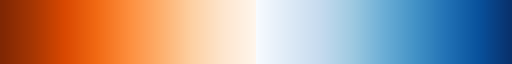

In [40]:
plt.style.use('fivethirtyeight')
# make drought cmap
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')
drought_cmp =[newcmp(i) for i in range(0,newcmp.N, 11)]
newcmp

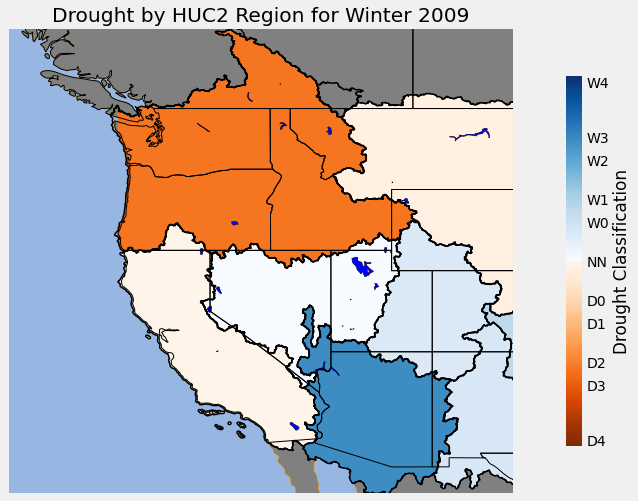

In [41]:
plt.figure(figsize=(16,8))

# get snow cmap
snow_cmap = matplotlib.cm.get_cmap('Blues_r')
#snow_cmap.set_bad(color='gray')

# get states
states = cfeature.NaturalEarthFeature(category='cultural',
                                     name='admin_1_states_provinces_shp',
                                     scale='50m',
                                     facecolor='none',
                                     edgecolor='black',
                                     linewidth=1)
# load projection
ax = plt.axes(projection=ccrs.PlateCarree())

# add land, lakes, oceans, and HUC2 regions
ax.add_feature(cfeature.LAND, edgecolor="orange", facecolor="grey", zorder=0)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor="blue")
ax.add_feature(cfeature.OCEAN)
ax.add_feature(HUC2)
# add states 
ax.add_feature(states)



# define new regionmask where values represent drought conditions
# uncomment when doing different year - save computation speed for now

dry = HUC2_drought.plot(ax=ax, transform = ccrs.PlateCarree(), add_colorbar=False,
         cmap=newcmp, vmin=-2.4, vmax=2.4)

#cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(cmap=newcmp, ax=ax, cax=cax)

cbar_ticks = [-2.3, -1.6, -1.3, -0.8, -0.5, 0, 0.5, 0.8, 1.3, 1.6, 2.3]
yticklabels=['D4', 'D3', 'D2', 'D1', 'D0', 'NN', 'W0', 'W1', 'W2', 'W3', 'W4']
cbar = plt.colorbar(dry, 
                   orientation='vertical',
                   shrink=0.8,
                   ticks=cbar_ticks)
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label("Drought Classification",  labelpad=4)


# set extent to Western US
ax.set_extent((-130, -105, 30, 53), crs=ccrs.PlateCarree())

# set plot attributes and labels
ax.set_title(f"Drought by HUC2 Region for Winter {year}");

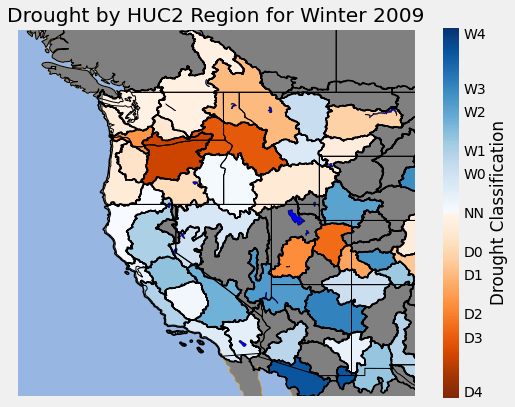

In [42]:
plt.figure(figsize=(8,8))
# load projection
ax = plt.axes(projection=ccrs.PlateCarree())

# add land, lakes, oceans, and HUC2 regions
ax.add_feature(cfeature.LAND, edgecolor="orange", facecolor="grey", zorder=0)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor="blue")
ax.add_feature(cfeature.OCEAN)
ax.add_feature(HUC4)
# add states 
ax.add_feature(states)



# define new regionmask where values represent drought conditions
# uncomment when doing different year - save computation speed for now

dry = HUC4_drought.plot(ax=ax, transform = ccrs.PlateCarree(), add_colorbar=False,
         cmap=newcmp, vmin=-2.4, vmax=2.4)

#cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(cmap=newcmp, ax=ax, cax=cax)

cbar_ticks = [-2.3, -1.6, -1.3, -0.8, -0.5, 0, 0.5, 0.8, 1.3, 1.6, 2.3]
yticklabels=['D4', 'D3', 'D2', 'D1', 'D0', 'NN', 'W0', 'W1', 'W2', 'W3', 'W4']
cbar = plt.colorbar(dry, 
                   orientation='vertical',
                   shrink=0.8,
                   ticks=cbar_ticks)
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label("Drought Classification",  labelpad=4)


# set extent to Western US
ax.set_extent((-130, -105, 30, 53), crs=ccrs.PlateCarree())

# set plot attributes and labels
ax.set_title(f"Drought by HUC2 Region for Winter {year}");

In [48]:
ds_new

<xarray.Dataset>
Dimensions:  (lat: 56, lon: 115, time: 35429)
Coordinates:
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 50.5 51.0 51.5 52.0 52.5
  * lon      (lon) float64 235.5 236.0 236.5 237.0 ... 291.0 291.5 292.0 292.5
  * time     (time) datetime64[ns] 1915-01-01 1915-01-02 ... 2011-12-31
Data variables:
    swe      (time, lat, lon) float32 ...
Attributes:
    SurfSgn_convention:  Traditional
    citation:            Livneh B, E.A. Rosenberg, C. Lin, B. Nijssen, V. Mis...
    references:          http://www.esrl.noaa.gov/psd/data/gridded/data.livne...
    institution:         Dataset provided by NOAA/ESRL PSD
    Conventions:         CF-1.2
    contact:             esrl.psd.data.gov
    version:             V4.1.2.c
    title:               Livneh daily CONUS near-surface gridded derived hydr...
    creation_method:     generated using the Variable Infiltration Capacity (...
    sources:             Livneh et al., 2013, J. Climate
    history:             Created at NOAA/ESRL PSD 2015/03/20 using files obta...
    dataset_title:       Livneh daily CONUS near-surface gridded meteorologic...